In [ ]:
import os
from joblib import dump
import shutil
from sklearn.model_selection import train_test_split


# Helper functions for data preprocessing and feature extraction
from methods.preprocessing import *
from methods.image_enhancement import *

# Machine Learning models and utilities
from methods.ml import *

# CNN models and utilities
from methods.cnn import *

# 1. Preprocessing and EDA (Exploratory Data Analysis)

In [2]:
# Read data in folder
train_dir = "/Users/dogukan/Developer/facerecognation/data/fer-2013-dataset/train"
shrunk_train_dir = "/Users/dogukan/Developer/facerecognation/data/fer-2013-dataset/shrunk_train"
for dirpath,dirname,filenames in os.walk(train_dir):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath[22:]}")

There are 7 directories and 0 images in er/facerecognation/data/fer-2013-dataset/train
There are 0 directories and 7215 images in er/facerecognation/data/fer-2013-dataset/train/happy
There are 0 directories and 4830 images in er/facerecognation/data/fer-2013-dataset/train/sad
There are 0 directories and 4097 images in er/facerecognation/data/fer-2013-dataset/train/fear
There are 0 directories and 3171 images in er/facerecognation/data/fer-2013-dataset/train/surprise
There are 0 directories and 4965 images in er/facerecognation/data/fer-2013-dataset/train/neutral
There are 0 directories and 3995 images in er/facerecognation/data/fer-2013-dataset/train/angry
There are 0 directories and 436 images in er/facerecognation/data/fer-2013-dataset/train/disgust


In [3]:
def shrink_dataset(original_dir, target_dir, shrink_factor=6):

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        
    for dirpath, dirnames, filenames in os.walk(original_dir):
        for dirname in dirnames:
            class_path = os.path.join(dirpath, dirname)
            images = os.listdir(class_path)
            
            keep_size = max(1, len(images) // shrink_factor)
            
            keep_images, _ = train_test_split(images, train_size=keep_size, shuffle=True)
            
            target_class_path = os.path.join(target_dir, dirname)
            if not os.path.exists(target_class_path):
                os.makedirs(target_class_path)
            
            for image_name in keep_images:
                src_path = os.path.join(class_path, image_name)
                dst_path = os.path.join(target_class_path, image_name)
                shutil.copy(src_path, dst_path)

In [4]:
shrink_dataset(train_dir, shrunk_train_dir, shrink_factor=6)

data_gen = create_data_gen()
train_generator = data_gen.flow_from_directory(
    shrunk_train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)

train_vgg_generator = data_gen.flow_from_directory(
    shrunk_train_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical"
)


Found 8760 images belonging to 7 classes.
Found 8760 images belonging to 7 classes.


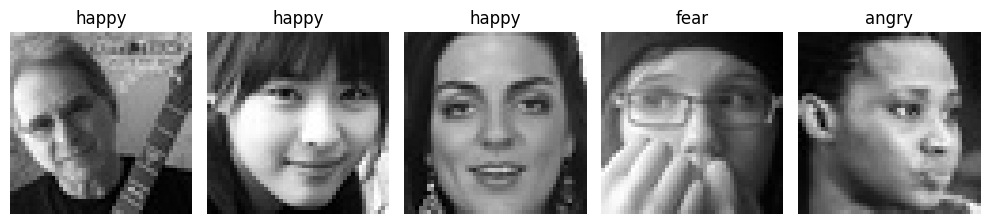

In [5]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())

images, labels = next(train_generator)
plot_example_images(images[:5], labels[:5], label_map)

# 2. Traditional Image Processing/Enhancement

Optionally, enhance images or extract features.\
Traditional image processing and enhancement techniques are foundational to improving the quality of images for various applications, from medical imaging to photography.\
In our project, we modeled many of these techniques in the "image_enhancement.py" file. These are,
- Image inpainting
- Linear filtering, smoothing
- Histogram equalization
- ...

[ WARN:0@501.132] global loadsave.cpp:248 findDecoder imread_('../data/fer-2013-data/train/angry/Training_6640570.jpg'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

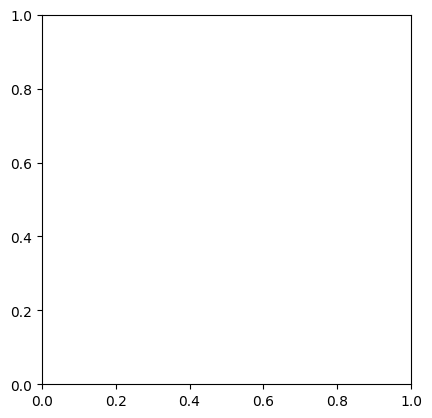

In [15]:
# This is an example image to show our enhancements on images
#improvable_image_path = "../data/fer-2013-data/train/angry/Training_2861857.jpg"
improvable_image_path = "../data/fer-2013-data/train/angry/Training_6640570.jpg"
show_image_as_plot(image_path=improvable_image_path)

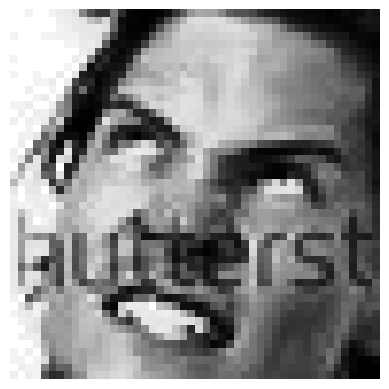

In [ ]:
hist_equalized_image = histogram_equalization(image_path=improvable_image_path)
show_image_as_plot(image=hist_equalized_image)

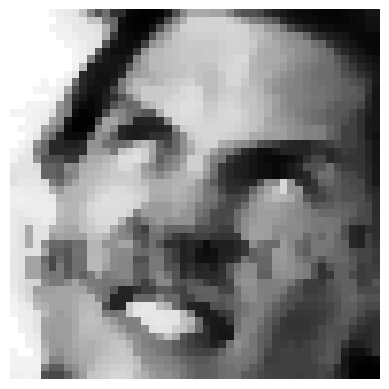

In [ ]:
median_blur_image = reduce_noise_median(image=hist_equalized_image)
show_image_as_plot(image=median_blur_image)

# 3. Feature Matching

Feature matching is widely used in machine learning models.
In our project, we modeled two of these techniques in the "image_enhancement.py" file. These are,
- SIFT
- HOG

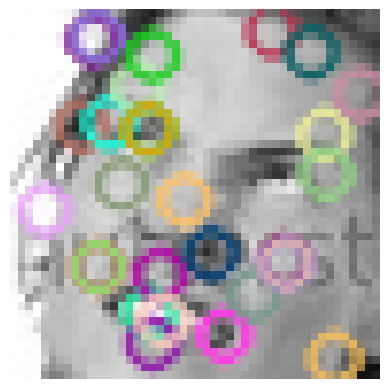

In [ ]:
sift_img, _= sift_creator(image_path=improvable_image_path)
show_image_as_plot(image=sift_img)

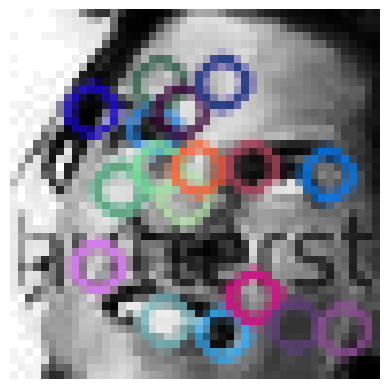

In [ ]:
sift_img, _= sift_creator(image=hist_equalized_image)
show_image_as_plot(image=sift_img)

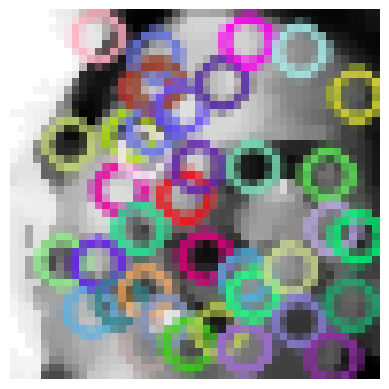

In [ ]:
sift_img, _= sift_creator(image=median_blur_image)
show_image_as_plot(image=sift_img)

# 4. ML Models

We will train 3 different ML models and compare them.
- SVM
- KNN
- Random Forest

Improving model accuracy through techniques such as feature matching and cross-validation, which are crucial for assessing the performance of machine learning models like SVM, KNN, and Random Forest in a more robust manner.

In [6]:
# Load train dataset
images_train, labels_train = load_dataset(shrunk_train_dir)

# Labels NumPy array
y_train = np.array(labels_train)

# Extract SIFT features
sift_features_train = extract_sift_features(images_train)
X_train_sift = np.array(sift_features_train)

# Extract HOG features
hog_features_train = extract_HOG_features(images_train)
X_train_hog = np.array(hog_features_train)

# Combine SIFT and HOG features
combined_features_train = combine_features(sift_features_train, hog_features_train)
X_train_combined = np.array(combined_features_train)

4.1. SVM (Support Vector Machine)

In [12]:
# sift + svm training
svm_classifier_sift = SVMClassifier()
svm_classifier_sift.train(X_train_sift, y_train)

# Save the trained model to a file
dump(svm_classifier_sift, "svm_classifier_sift.joblib")

In [ ]:
# hog + svm training
svm_classifier_hog = SVMClassifier()
svm_classifier_hog.train(X_train_hog, y_train)

# Save the trained model to a file
dump(svm_classifier_sift, "svm_classifier_hog.joblib")

In [ ]:
# combined + svm training
svm_classifier_combined = SVMClassifier()
svm_classifier_combined.train(X_train_combined, y_train)

# Save the trained model to a file
dump(svm_classifier_combined, "svm_classifier_combined.joblib")

4.2 KNN (K-Nearest Neighbors)

In [7]:
# sift + knn training
knn_classifier_sift = KNNClassifier()
knn_classifier_sift.train(X_train_sift, y_train)

# Save the trained model to a file
dump(knn_classifier_sift, "knn_classifier_sift.joblib")

['knn_classifier_sift.joblib']

In [8]:
# hog + knn training
knn_classifier_hog = KNNClassifier()
knn_classifier_hog.train(X_train_hog, y_train)

# Save the trained model to a file
dump(knn_classifier_hog, "knn_classifier_hog.joblib")

['knn_classifier_hog.joblib']

In [9]:
# combined + knn training
knn_classifier_combined = KNNClassifier()
knn_classifier_combined.train(X_train_combined, y_train)

# Save the trained model to a file
dump(knn_classifier_combined, "knn_classifier_combined.joblib")

['knn_classifier_combined.joblib']

4.3 Random Forest

In [15]:
# sift + random forest training
rf_classifier_sift = RandomForestClassifier()
rf_classifier_sift.train(X_train_sift, y_train)

# Save the trained model to a file
dump(rf_classifier_sift, "rf_classifier_sift.joblib")

RecursionError: maximum recursion depth exceeded

In [11]:
# hog + random forest training
rf_classifier_hog = RandomForestClassifier()
rf_classifier_hog.train(X_train_hog, y_train)

# Save the trained model to a file
dump(rf_classifier_hog, "rf_classifier_hog.joblib")

RecursionError: maximum recursion depth exceeded

In [12]:
# combined + random forest training
rf_classifier_combined = RandomForestClassifier()
rf_classifier_combined.train(X_train_combined, y_train)

# Save the trained model to a file
dump(rf_classifier_combined, "rf_classifier_combined.joblib")

RecursionError: maximum recursion depth exceeded

# 5. CNN Models

Since CNNs are highly capable of learning relevant features from raw images, and training directly on images will give better results compared to using manually extracted features, it is trained by raw images.

In [14]:
cnn_model = cnn()
cnn_model.train(train_generator, epochs=50)
model_path = "cnn_model.h5"
cnn_model.model.save(model_path)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2406 - loss: 1.8421
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.2471 - loss: 1.8124
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.2900 - loss: 1.7515
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3374 - loss: 1.6826
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3437 - loss: 1.6702
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3734 - loss: 1.6130
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3825 - loss: 1.6039
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3932 - loss: 1.5702
Epoch 9/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4028 - loss: 1.5562
Epoch 10/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4171 - loss: 1.5348
Epoch 11/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4323 - loss: 1.4975
Epoch 12/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
cnn_vgg = cnn_vgg()
cnn_vgg.train(train_vgg_generator, epochs=50)
model_path = "cnn_vgg.h5"
cnn_vgg.model.save(model_path)

In [ ]:
cnn_resnet = cnn_resnet()
cnn_resnet.train(train_vgg_generator, epochs=50)
model_path = "cnn_resnet.h5"
cnn_resnet.model.save(model_path)